# Freq-E example usage 
Starting with a collection of text documents. This notebook walks through: 

1. Pre-processing text to be in a format suitable for input into freq-e

2. How to run freq-e to obtain prevalence estimates on the test set. 

In [1]:
from __future__ import division, print_function
import numpy as np 
import json
from sklearn.feature_extraction import DictVectorizer

In [2]:
import estimate; reload(estimate)
%load_ext autoreload
%autoreload 2

## Pre-processing 
We will use the Yelp academic dataset as an example. The text representation will be unigram counts (e.g. "bag-of-words") which have already been processed and loaded. 

X : numpy.ndarray

y : numpy.ndarray 

In [3]:
def load_x_y_from_json(file_name): 
    count_dicts = []
    y = []
    for line in open(file_name): 
        dd = json.loads(line)
        counts = dd['counts'].copy()
        cc = dd['class']
        count_dicts.append(counts); y.append(cc)
    return count_dicts, np.array(y)  

In [4]:
#get train data 
dv = DictVectorizer()
train_count_dicts, y_train = load_x_y_from_json('example_data/train_yelp.json')
X_train = dv.fit_transform(train_count_dicts).toarray()
dv_vocab = np.array(dv.feature_names_)
print(type(X_train), type(y_train))
print(X_train.shape, y_train.shape)
assert X_train.shape[0] == y_train.shape[0]

<type 'numpy.ndarray'> <type 'numpy.ndarray'>
(2000, 14791) (2000,)


In [5]:
# get test data (1 test group) 
# NOTE: the test group is the "inference" group in a real-word setting
# here we have labels on the test set, but in a real-word setting there 
# would most likely not be labels on the test set
test_count_dicts, y_test = load_x_y_from_json('example_data/test_yelp.json')
X_test = dv.transform(test_count_dicts).toarray()
print(type(X_test), type(y_test))
print(X_test.shape, y_test.shape)

<type 'numpy.ndarray'> <type 'numpy.ndarray'>
(2000, 14791) (2000,)


## Freq-e usage

### Training 
- In order to select the best discriminitive classifier, we will do a grid search over the L1 penalties for LogReg, evaluating on cross-entropy over 10 cross-validation folds 

In [6]:
freq_e = estimate.FreqEstimate(conf_level=0.95)
trained_model = freq_e.fit(X_train, y_train)
print(trained_model.C)

TRAINING DISCRIMINATIVE MODEL


/usr/local/lib/python2.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=0.0009765625, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l1', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)
Training mean accuracy= 0.737
0.0009765625


### Inference
Returns (1) a point estimate of the class frequency/proportions and (2) a confidence interval for the point estimate. 

In [7]:
# here we can know the true proportions because we have access to the test labels 
print('TRUE')
print(np.mean(y_test))

TRUE
0.769


In [8]:
#naive method = PCC (probabilistic classify and count)
print('PCC')
print(np.mean(trained_model.predict_proba(X_test)[:, 1]))

PCC
0.584842286869


In [9]:
print(trained_model.predict_proba(X_test))

[[ 0.28205652  0.71794348]
 [ 0.48702675  0.51297325]
 [ 0.38529299  0.61470701]
 ..., 
 [ 0.44828101  0.55171899]
 [ 0.42276627  0.57723373]
 [ 0.30354483  0.69645517]]


In [18]:
print('FREQ-E ESTIMATED')
out = freq_e.predict_freq(trained_model, X_train, y_train, X_test)
print(out)

FREQ-E ESTIMATED
{'conf_interval': (0.001, 0.0030000000000000001), 'point': 0.001}


### debugging

In [11]:
from estimate import *

In [12]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline


Double-checking that model.decision function is what I want

From: https://github.com/scikit-learn/scikit-learn/blob/7389dba/sklearn/linear_model/base.py#L264

scores = safe_sparse_dot(X, self.coef_.T,
                                 dense_output=True) + self.intercept_
                                 
so decision function should just be WX + b 


In [13]:
train_prior = np.mean(y_train)
print(train_prior)
log_odds =trained_model.decision_function(X_test)
print(log_odds)
print(len(log_odds))
log_post_probs = mll_curve_stable(log_odds, train_prior)
log_prior = get_beta_prior()
log_post_probs = np.add(log_post_probs, log_prior)

0.7655
[ 0.93428339  0.05190463  0.46714169 ...,  0.20761853  0.3114278
  0.83047412]
2000


In [14]:
print(log_post_probs)

[ -1.05434628e+00  -2.10890092e+00  -3.16425245e+00  -4.22038358e+00
  -5.27728869e+00  -6.33496514e+00  -7.39341142e+00  -8.45262652e+00
  -9.51260977e+00  -1.05733606e+01  -1.16348787e+01  -1.26971636e+01
  -1.37602150e+01  -1.48240329e+01  -1.58886169e+01  -1.69539668e+01
  -1.80200827e+01  -1.90869642e+01  -2.01546115e+01  -2.12230243e+01
  -2.22922027e+01  -2.33621466e+01  -2.44328560e+01  -2.55043309e+01
  -2.65765714e+01  -2.76495773e+01  -2.87233489e+01  -2.97978862e+01
  -3.08731892e+01  -3.19492580e+01  -3.30260927e+01  -3.41036935e+01
  -3.51820605e+01  -3.62611937e+01  -3.73410934e+01  -3.84217598e+01
  -3.95031929e+01  -4.05853929e+01  -4.16683601e+01  -4.27520947e+01
  -4.38365969e+01  -4.49218668e+01  -4.60079048e+01  -4.70947110e+01
  -4.81822858e+01  -4.92706294e+01  -5.03597420e+01  -5.14496240e+01
  -5.25402756e+01  -5.36316971e+01  -5.47238889e+01  -5.58168513e+01
  -5.69105845e+01  -5.80050889e+01  -5.91003649e+01  -6.01964128e+01
  -6.12932330e+01  -6.23908257e+01

In [15]:
print(np.exp(log_post_probs[0]))

0.348420122517


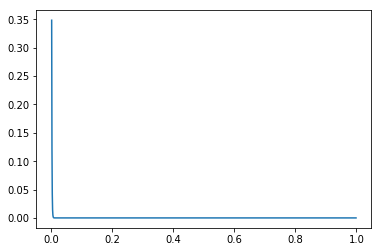

In [16]:
plt.plot(estimate.trange, np.exp(log_post_probs))
plt.show()

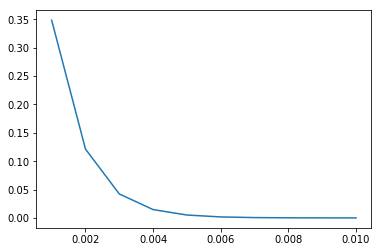

In [17]:
plt.plot(estimate.trange[0:10], np.exp(log_post_probs[0:10]))
plt.show()